In [1]:
import pandas as pd
import pyodbc

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import math
import numpy as np

from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import anderson_ksamp

from sklearn.model_selection import train_test_split

In [2]:
# display options

pd.options.display.max_columns = 150
pd.options.display.max_rows = 1000
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('whitegrid')

In [3]:
# connect to db    

conn_str = (
    "DRIVER={PostgreSQL ODBC driver(ANSI)};"
    "DATABASE=postgres;"
    "UID=postgres;"
    "PWD=*****;"
    "SERVER=localhost;"
    "PORT=5432;"
    )

cncx = pyodbc.connect(conn_str)

In [4]:
# executing a query and convert result to pandas dataframe
# change variables according to your case

responce_col_for_query = '"Total_claim_amount"'
responce_col = 'Total_claim_amount'
my_table = 'verylargetable2'
sSQL = 'select ctid as rowid, ' + responce_col_for_query + ' from ' + my_table #PostgreSql
print(sSQL)
%time data = pd.read_sql(sSQL, cncx)

select ctid as rowid, "Total_claim_amount" from verylargetable2
Wall time: 358 ms


In [5]:
data.head()

,rowid,Total_claim_amount
0,"(172,38)",792.00
1,"(174,38)",83.24
2,"(232,38)",590.40
3,"(239,38)",384.00
4,"(240,35)",384.81


In [6]:
# function to make sure that there are at least <threshold> elements in each bin
# (at least 2 is mandatory for strat. sampling).
def f_create_bins(data, bins, treshold):
    x = np.array(data)
    bins = np.array(bins)
    n = np.digitize(x, bins)
    #in case of passing np.array
    n = n.flatten()
    #unique labels, ascending order
    n_unique = np.unique(n)
    
    for idx, i in np.ndenumerate(n_unique):
        if (sum(n == i) < treshold):
            # if label is not last and insufficiently populated --
            # we replace its value by the next one 
            if (idx[0] != n_unique.size - 1):
                n[n == i] = n_unique[idx[0]+1]
            # if label is last and insufficiently populated --
            # we replace it by highest from already redefined n
            else:
                largest_el = n[np.searchsorted(n, i, 'left') - 1] #search for highest elmnt that < i in n
                n[n == i] = largest_el 
    return n #, np.bincount(n)

In [7]:
#main function for stratified sampling
def stratified_sampling(data, responce_name, number_of_bins, threshold = 2, random_state = None):
    X = data.drop([responce_name], axis = 1)
    y = data[responce_name]
    min_resp = np.floor(y.min())
    max_resp = np.ceil(y.max())
    #initial binning (user defined)
    bins_start = np.linspace(min_resp, max_resp, number_of_bins)
    try:
        y_binned = np.digitize(y, bins_start)
        X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, stratify=y_binned, test_size=0.2, random_state = random_state)
    #if there are bins with < <threshold> elements
    except ValueError:
        #merge neighbour bins until there is no insufficiently populated bins
        y_binned = f_create_bins(y, bins_start, threshold)
        X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, stratify=y_binned, test_size=0.2, random_state = random_state)
    return X_train_s, X_test_s, y_train_s, y_test_s

In [8]:
#testing function
x = [-265, -200,  300, 355, 2900, 3100, 6600]
bins = [-300, 0, 200, 400, 5000]
f_create_bins(x, bins, 2)

array([1, 1, 3, 3, 4, 4, 4], dtype=int64)

C:\Users\Wress\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


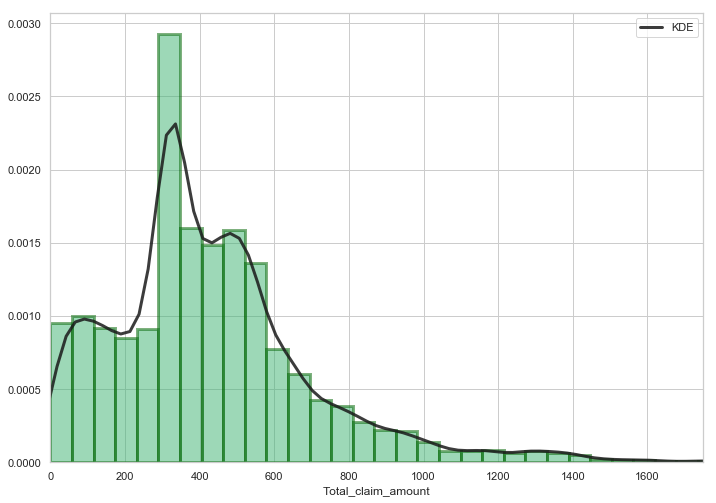

In [9]:
#responce distribution plot
sns.distplot(data[responce_col], kde=True, bins = 50,
             kde_kws = {"color": "k", "alpha":0.85, "lw": 3, "label":"KDE"},
             hist_kws = {"histtype":"bar", "linewidth":3, "alpha": 0.5, "color": "mediumseagreen", "edgecolor" : "darkgreen"}).set(xlim=(0, 1750))
plt.show()

In [10]:
# train/test split using stratified sampling
%time X_train_s, X_test_s, y_train_s, y_test_s = stratified_sampling(data, responce_col, 100, 2)

Wall time: 5.8 s


C:\Users\Wress\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


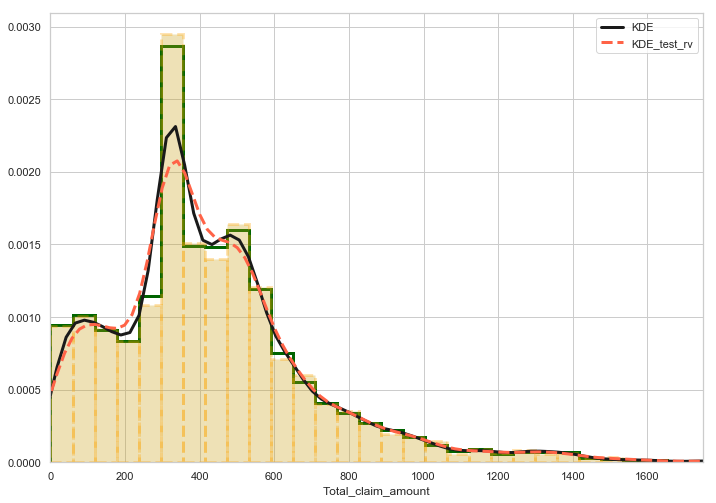

In [11]:
#compare sampled set and full data set distributions
bins_ = np.linspace(min(data[responce_col]), max(data[responce_col]), num = 50)

sns.distplot(data[responce_col], kde=True, bins = bins_,
             kde_kws = {"color": "k", "alpha":1, "lw": 3, "label":"KDE"},
             hist_kws = {"histtype":"step", "linewidth":3, "alpha": 1, "color": "mediumseagreen", "edgecolor" : "darkgreen"}).set(xlim=(0, 1750))

sns.distplot(y_test_s, kde=True, bins = bins_,
             kde_kws = {"color": "tomato", "alpha":1, "lw": 3,'linestyle':'--', "label":"KDE_test_rv"},
             hist_kws = {"histtype":"bar", "linewidth":3, 'linestyle': '--', "alpha":0.3 , "color": "#C99E10", "edgecolor" : "orange"})
plt.show()

In [12]:
#2-sample Kolmogorov-Smirnov test
ks_statistics, ks_pvalue = ks_2samp(data[responce_col].values, y_test_s.values)
print()
print('KS statistics is: ', ks_statistics)
print('---------------------------------------')
print('KS pvalue is: ', ks_pvalue * 100, '%')


KS statistics is:  0.00847534411029649
---------------------------------------
KS pvalue is:  99.98977328847268 %


In [13]:
#2-sample Anderson/Darling test
ad_statistics, crit_values, ad_pvalue = anderson_ksamp([data[responce_col].values, y_test_s.values])
print()
print('AD significance level is', ad_pvalue * 100, '%') #computed by extrapolation


AD significance level is 135.01977094936439 %


C:\Users\Wress\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1694: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


In [14]:
#add flags for train/test split in database table: 0 -- test, 1 -- train.
data['tt_flag'] = 0
data.loc[X_train_s.index, 'tt_flag'] = 1

In [15]:
#Add flags for sampled data to Database table

#convert dataframe to list of tuples
subset = data[['tt_flag', 'rowid']]
params = [tuple(x) for x in subset.values]

#check if column already exists
cursor = cncx.cursor()
sql_col = "SELECT column_name FROM information_schema.columns WHERE table_name='" + my_table + "' and column_name='tt_flag'";
cursor.execute(sql_col)
col_flag = cursor.fetchone()
cursor.close()

if col_flag is None:
    cursor = cncx.cursor()
    cursor.execute("ALTER TABLE " + my_table + " ADD tt_flag INT")
    cursor.commit()
    cursor.close()

#inserting tuples into database
cncx.autocommit = False
cursor = cncx.cursor()

updateSQL = 'update '+ my_table + ' set tt_flag = ? where ctid = ?'
#can boost the performance of "executemany" operations. Remove if necessary
cncx.cursor().fast_executemany = True
%time cursor.executemany(updateSQL, params)

#cursor.executemany("update  into t(name, id) values (?, ?)", params)

cncx.commit()
cursor.close()

Wall time: 2.62 s
